**Todos**
- [x] Try Cresswell & Nelson 2008 Te 
- [x] Write up equations

# Preamble

In [3]:
from sympy import init_session
import LaplaceCoefficients
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_styles import analytic
import numpy as npy
import scipy as sp
%matplotlib widget
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle
from sympy.utilities.lambdify import lambdastr
import io, subprocess
def save_to_clipboard(dpi=300):
    plt.savefig("/tmp/clipboard.png", format="png", bbox_inches="tight", dpi=dpi)
    subprocess.run(
        [
            "osascript",
            "-e",
            f'set the clipboard to (read (POSIX file "/tmp/clipboard.png") as «class PNGf»)',
        ]
    )
init_session()

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



## Symbols

In [ ]:
# Positive constant
M, G, q, mu1, mu2, m1, m2, b1, b2, j, b1_3_2, b2_3_2 = symbols(
    r"M G q mu_1 mu_2 m_1, m_2, beta_1 beta_2 j b_{3/2}^{(1)}(\alpha_0) b_{3/2}^{(2)}(\alpha_0)",
    positive=True,
)
# Positive timescales
Tm1, Tm2, Te1, Te2 = symbols(
    r"T_{m\,1} T_{m\,2} T_{e\,1} T_{e\,2}",
    positive=True,
)
# Precession frequencies
om1, om2 = symbols("omega_1 omega_2")
# Angles of time
l1, l2, pom1, pom2, th1, th2, th0 = symbols(
    "l_1 l_2 varpi_1 varpi_2 theta_1 theta_2 theta_0"
)
# Positive functions of time
e1, e2, a1, a2, n1, n2, alpha = symbols(
    "e_1 e_2 a_1 a_2 n_1 n_2 \\alpha_{12}", positive=True
)
# Actions
Gam1, Gam2, Lam1, Lam2 = symbols("Gamma_1 Gamma_2 Lambda_1 Lambda_2", positive=True)
# Derivatives
dth1, dth2 = symbols(r"\dot\theta_1 \dot\theta_2")
# Giant outer planet
alpha13, b1_3_2_13, b2_3_2_13, mu3, e3, pom3, a3 = symbols(
    r"\alpha_{13} b_{3/2}^{(1)}(\alpha_{13}) b_{3/2}^{(2)}(\alpha_{13}) mu_3 e_3 \varpi_3 a_3",
    positive=True,
)
alpha23, b1_3_2_23, b2_3_2_23 = symbols(
    r"\alpha_{23} b_{3/2}^{(1)}(\alpha_{23}) b_{3/2}^{(2)}(\alpha_{23})", positive=True
)

In [5]:
EXPRS = {}
EXPRS[th1] = (j + 1) * l2 - j * l1 - pom1
EXPRS[th2] = (j + 1) * l2 - j * l1 - pom2
EXPRS[Lam1] = q * sqrt(a1)
EXPRS[Lam2] = sqrt(a2)
EXPRS[Gam1] = Rational(1, 2) * q * sqrt(a1) * e1**2
EXPRS[Gam2] = Rational(1, 2) * sqrt(a2) * e2**2

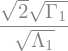

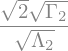

In [6]:
CANON = {}
CANON[a1] = solve(EXPRS[Lam1] - Lam1, a1)[0]
CANON[e1] = solve(EXPRS[Gam1] - Gam1, e1)[0].subs(a1, CANON[a1])
CANON[a2] = solve(EXPRS[Lam2] - Lam2, a2)[0]
CANON[e2] = solve(EXPRS[Gam2] - Gam2, e2)[0].subs(a2, CANON[a2])
display(CANON[a1])
display(CANON[e1])
display(CANON[a2])
display(CANON[e2])

## Helper functions

In [7]:
def term_simplify(expr):
    run = 0
    for arg in expr.args:
        run += arg.simplify()
    return run


def term_multiply(expr, mult):
    run = 0
    for term in expr.args:
        run += term * mult
    term_simplify(run)
    return run


def chain_rule(expr, var):
    run = expr.diff(var)
    for key in EXPRS.keys():
        run += expr.diff(key) * EXPRS[key].diff(var)
    for key in CANON.keys():
        run += expr.diff(key) * CANON[key].diff(var)
    return run


def to_orbelts(expr):
    for var in [Lam1, Lam2, Gam1, Gam2]:
        expr = expr.subs(var, EXPRS[var])
    return expr

## Resonant Hamiltonian

- Assume $a_2\approx a_{2,0}[=1]$ in denominator of perturbation term.
- $\beta_1=-f_{27}(\alpha_0)$ and $\beta_2=f_{31}(\alpha_0)$ 

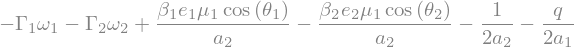

In [8]:
H_expr = (
    -Rational(1, 2) * q / a1
    - Rational(1, 2) * 1 / a2
    + mu1 * b1 * e1 * cos(th1) / a2
    - mu1 * b2 * e2 * cos(th2) / a2
    - Gam1 * om1
    - Gam2 * om2
)
H_expr

## Secular interactions $m_1-m_2$

Doing 2 different R_i for each planet to reduce typos over from Murray & Dermott.

Units are in $[n_{2,0}]$, $[a_{2,0}]$, and $[M]$

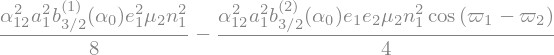

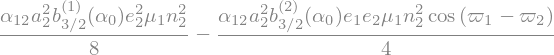

In [9]:
# A11 = Rational(1,4)*n1*m2/(M+m1)*alpha*alpha*b1_3_2
# A12 = -Rational(1,4)*n1*m2/(M+m1)*alpha*alpha*b2_3_2
# A21 = -Rational(1,4)*n2*m1/(M+m2)*alpha*b2_3_2
# A22 = Rational(1,4)*n2*m1/(M+m2)*alpha*b1_3_2
A11 = Rational(1, 4) * n1 * mu2 * alpha * alpha * b1_3_2
A12 = -Rational(1, 4) * n1 * mu2 * alpha * alpha * b2_3_2
A21 = -Rational(1, 4) * n2 * mu1 * alpha * b2_3_2
A22 = Rational(1, 4) * n2 * mu1 * alpha * b1_3_2

R1 = (
    n1 * a1**2 * (Rational(1, 2) * A11 * e1**2 + A12 * e1 * e2 * cos(pom1 - pom2))
).expand()
R2 = (
    n2 * a2**2 * (Rational(1, 2) * A22 * e2**2 + A21 * e1 * e2 * cos(pom1 - pom2))
).expand()
# term_multiply(R1.expand().subs(n1**2,G*M*m1/a1**3),1/(G*M*m2)).subs({m1:mu1*M,m2:mu2*M}).cancel()
display(R1)
display(R2)

In [10]:
print(latex(R1))
print(latex(R2))

\frac{\alpha_{12}^{2} a_{1}^{2} b_{3/2}^{(1)}(\alpha_0) e_{1}^{2} \mu_{2} n_{1}^{2}}{8} - \frac{\alpha_{12}^{2} a_{1}^{2} b_{3/2}^{(2)}(\alpha_0) e_{1} e_{2} \mu_{2} n_{1}^{2} \cos{\left(\varpi_{1} - \varpi_{2} \right)}}{4}
\frac{\alpha_{12} a_{2}^{2} b_{3/2}^{(1)}(\alpha_0) e_{2}^{2} \mu_{1} n_{2}^{2}}{8} - \frac{\alpha_{12} a_{2}^{2} b_{3/2}^{(2)}(\alpha_0) e_{1} e_{2} \mu_{1} n_{2}^{2} \cos{\left(\varpi_{1} - \varpi_{2} \right)}}{4}


## Secular interactions with $m_3$

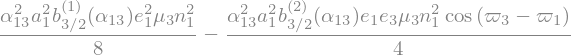

In [11]:
A11 = Rational(1, 4) * n1 * mu3 * alpha13 * alpha13 * b1_3_2_13
A13 = -Rational(1, 4) * n1 * mu3 * alpha13 * alpha13 * b2_3_2_13

R13 = (
    n1 * a1**2 * (Rational(1, 2) * A11 * e1**2 + A13 * e1 * e3 * cos(pom1 - pom3))
).expand()
display(R13)

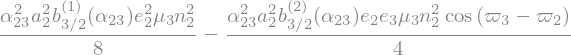

In [ ]:
A22 = Rational(1, 4) * n2 * mu3 * alpha23 * alpha23 * b1_3_2_23
A23 = -Rational(1, 4) * n2 * mu3 * alpha23 * alpha23 * b2_3_2_23

R23 = (
    n2 * a2**2 * (Rational(1, 2) * A22 * e2**2 + A23 * e2 * e3 * cos(pom2 - pom3))
).expand()
display(R23)

In [13]:
print(latex(R13))
print(latex(R23))

\frac{\alpha_{13}^{2} a_{1}^{2} b_{3/2}^{(1)}(\alpha_{13}) e_{1}^{2} \mu_{3} n_{1}^{2}}{8} - \frac{\alpha_{13}^{2} a_{1}^{2} b_{3/2}^{(2)}(\alpha_{13}) e_{1} e_{3} \mu_{3} n_{1}^{2} \cos{\left(\varpi_{3} - \varpi_{1} \right)}}{4}
\frac{\alpha_{23}^{2} a_{2}^{2} b_{3/2}^{(1)}(\alpha_{23}) e_{2}^{2} \mu_{3} n_{2}^{2}}{8} - \frac{\alpha_{23}^{2} a_{2}^{2} b_{3/2}^{(2)}(\alpha_{23}) e_{2} e_{3} \mu_{3} n_{2}^{2} \cos{\left(\varpi_{3} - \varpi_{2} \right)}}{4}


# Equations of motion

## Resonant

### $\dot\Lambda_1$, $\dot\Lambda_2$

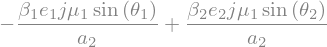

In [14]:
Lam1_dot_res = -chain_rule(H_expr, l1)
Lam1_dot_res

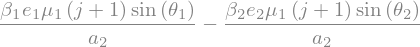

In [15]:
Lam2_dot_res = -chain_rule(H_expr, l2)
Lam2_dot_res

### $\dot n_1$, $\dot n_2$

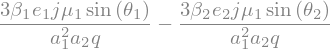

In [16]:
n1_dot_res = term_multiply(Lam1_dot_res, -3 * q**3 / Lam1**4).subs(Lam1, EXPRS[Lam1])
n1_dot_res

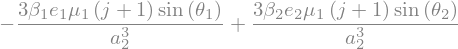

In [17]:
n2_dot_res = term_multiply(Lam2_dot_res, -3 / Lam2**4).subs(Lam2, EXPRS[Lam2])
n2_dot_res

### $\dot\Gamma_1$, $\dot\Gamma_2$

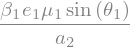

In [18]:
Gam1_dot_res = chain_rule(H_expr, pom1)
Gam1_dot_res

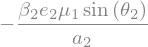

In [19]:
Gam2_dot_res = chain_rule(H_expr, pom2)
Gam2_dot_res

### $\dot\varpi_1$, $\dot\varpi_2$

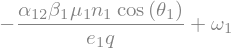

In [20]:
pom1_dot_res = (
    to_orbelts(-chain_rule(H_expr, Gam1))
    .subs(a2, a1 / alpha)
    .subs(a1, n1 ** Rational(-2, 3))
)
pom1_dot_res

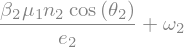

In [21]:
pom2_dot_res = to_orbelts(-chain_rule(H_expr, Gam2)).subs(a2, n2 ** Rational(-2, 3))
pom2_dot_res

### $\dot\lambda_1$, $\dot\lambda_2$

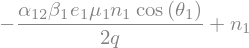

In [22]:
l1_dot_res = (
    to_orbelts(chain_rule(H_expr, Lam1))
    .subs(a2, a1 / alpha)
    .subs(a1, n1 ** Rational(-2, 3))
)
l1_dot_res

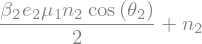

In [23]:
l2_dot_res = (
    to_orbelts(
        chain_rule(
            H_expr.subs(b2 / a2, b2 * alpha / a1).subs(b1 / a2, b1 * a1 / alpha), Lam2
        )
    )
    .subs(a1, alpha * a2)
    .subs(a2, n2 ** Rational(-2, 3))
)
l2_dot_res

### $\dot e_1$, $\dot e_2$

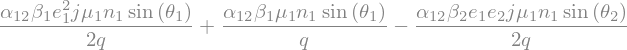

In [24]:
# edot = Gamdot/(Lam*e) - term_multiply(Lamdot, Rational(1,2)/Lam*e)
e1_dot_res = (
    to_orbelts(
        Gam1_dot_res / (Lam1 * e1)
        - term_multiply(Lam1_dot_res, Rational(1, 2) / Lam1 * e1)
    )
    .subs(a2, a1 / alpha)
    .subs(a1, n1 ** Rational(-2, 3))
)
e1_dot_res

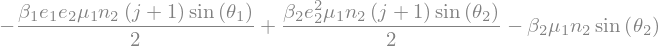

In [25]:
e2_dot_res = to_orbelts(
    Gam2_dot_res / (Lam2 * e2) - term_multiply(Lam2_dot_res, Rational(1, 2) / Lam2 * e2)
).subs(a2, n2 ** Rational(-2, 3))
e2_dot_res

### $\dot\theta_0$

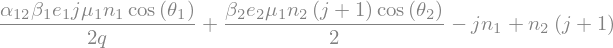

In [26]:
th0_dot_res = term_multiply(l2_dot_res, j + 1) - term_multiply(l1_dot_res, j)
th0_dot_res

## Secular

### $\dot e_{1,\rm sec}$, $\dot e_{2,\rm sec}$

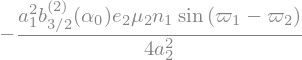

In [27]:
e1_dot_sec = -R1.diff(pom1).subs(alpha, a1 / a2) / (n1 * a1**2 * e1)
e1_dot_sec

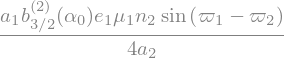

In [28]:
e2_dot_sec = -R2.diff(pom2).subs(alpha, a1 / a2) / (n2 * a2**2 * e2)
e2_dot_sec

### $\dot \varpi_{1,\rm sec}$, $\dot \varpi_{2,\rm sec}$

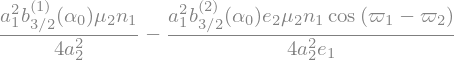

In [29]:
pom1_dot_sec = term_multiply(R1.diff(e1), 1 / (n1 * a1**2 * e1)).subs(alpha, a1 / a2)
pom1_dot_sec

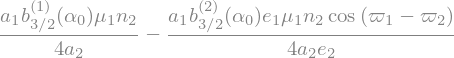

In [30]:
pom2_dot_sec = term_multiply(R2.diff(e2), 1 / (n2 * a2**2 * e2)).subs(alpha, a1 / a2)
pom2_dot_sec

### $\dot e_{1,3},\dot e_{2,3}$

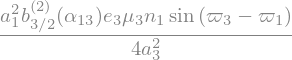

In [31]:
e1_dot_sec13 = -R13.diff(pom1).subs(alpha13, a1 / a3) / (n1 * a1**2 * e1)
e1_dot_sec13

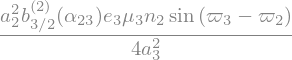

In [32]:
e2_dot_sec23 = -R23.diff(pom2).subs(alpha23, a2 / a3) / (n2 * a2**2 * e2)
e2_dot_sec23

### $\dot \varpi_{1,3},\dot \varpi_{2,3}$

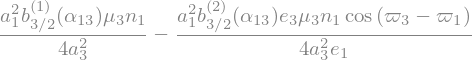

In [ ]:
pom1_dot_sec13 = term_multiply(R13.diff(e1), 1 / (n1 * a1**2 * e1)).subs(
    alpha13, a1 / a3
)
pom1_dot_sec13

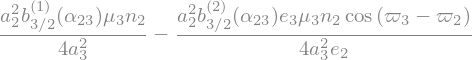

In [ ]:
pom2_dot_sec23 = term_multiply(R23.diff(e2), 1 / (n2 * a2**2 * e2)).subs(
    alpha23, a2 / a3
)
pom2_dot_sec23

## Dissipative

### $\dot a_{1,\rm dis}$, $\dot a_{2,\rm dis}$

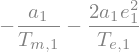

In [35]:
a1_dot_dis = term_multiply(-1 / Tm1 - 2 * e1**2 / Te1, a1)
a1_dot_dis

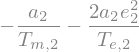

In [36]:
a2_dot_dis = term_multiply(-1 / Tm2 - 2 * e2**2 / Te2, a2)
a2_dot_dis

In [37]:
print(latex(a1_dot_dis))
print(latex(a2_dot_dis))

- \frac{a_{1}}{T_{m,1}} - \frac{2 a_{1} e_{1}^{2}}{T_{e,1}}
- \frac{a_{2}}{T_{m,2}} - \frac{2 a_{2} e_{2}^{2}}{T_{e,2}}


### $\dot n_{1,\rm dis}$, $\dot n_{2,\rm dis}$

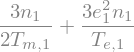

In [38]:
n1_dot_dis = term_multiply(a1_dot_dis, -Rational(3, 2) * n1 / a1)
n1_dot_dis

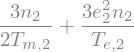

In [39]:
n2_dot_dis = term_multiply(a2_dot_dis, -Rational(3, 2) * n2 / a2)
n2_dot_dis

### $\dot e_{1,\rm dis}$, $\dot e_{2,\rm dis}$

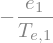

In [40]:
e1_dot_dis = -e1 / Te1  # (Te1* (1 + exp(e1 / 0.01)) / 2)
e1_dot_dis

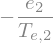

In [41]:
e2_dot_dis = -e2 / Te2  # (Te2* (1 + exp(e2 / 0.01)) / 2)
e2_dot_dis

In [42]:
print(latex(e1_dot_dis))
print(latex(e2_dot_dis))

- \frac{e_{1}}{T_{e,1}}
- \frac{e_{2}}{T_{e,2}}


### Cresswell & Nelson 2008 eccentricity damping

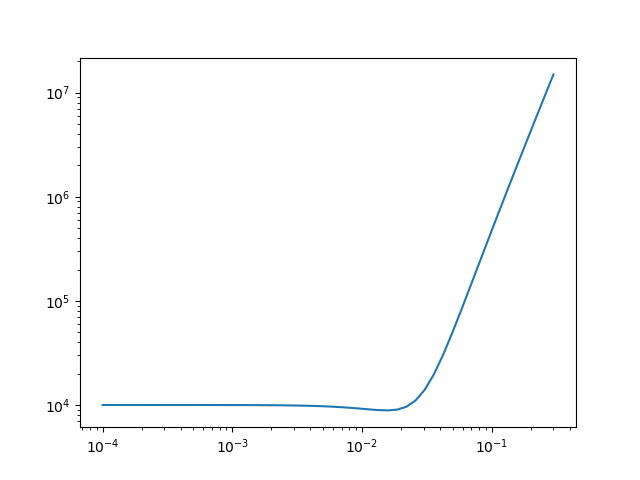

In [ ]:
ecc = npy.logspace(-4, np.log10(0.3))
h = 0.01
twave = 1e8 * h**2
te = twave * (1 - 0.14 * (ecc / h) ** 2 + 0.06 * (ecc / h) ** 3)
plt.clf()
plt.plot(ecc, te)
plt.xscale("log")
plt.yscale("log")
plt.show()

# Latex

In [ ]:
print(latex(n1_dot_res + n1_dot_dis))

\frac{3 \beta_{1} e_{1} j \mu_{1} \sin{\left(\theta_{1} \right)}}{a_{1}^{2} a_{2} q} - \frac{3 \beta_{2} e_{2} j \mu_{1} \sin{\left(\theta_{2} \right)}}{a_{1}^{2} a_{2} q} + \frac{3 n_{1}}{2 T_{m,1}} + \frac{3 e_{1}^{2} n_{1}}{T_{e,1}}


In [ ]:
print(latex(n2_dot_res + n2_dot_dis))

- \frac{3 \beta_{1} e_{1} \mu_{1} \left(j + 1\right) \sin{\left(\theta_{1} \right)}}{a_{2}^{3}} + \frac{3 \beta_{2} e_{2} \mu_{1} \left(j + 1\right) \sin{\left(\theta_{2} \right)}}{a_{2}^{3}} + \frac{3 n_{2}}{2 T_{m,2}} + \frac{3 e_{2}^{2} n_{2}}{T_{e,2}}


In [ ]:
print(latex(e1_dot_res + e1_dot_sec + e1_dot_sec13 + e1_dot_dis))

\frac{\alpha_{12} \beta_{1} e_{1}^{2} j \mu_{1} n_{1} \sin{\left(\theta_{1} \right)}}{2 q} + \frac{\alpha_{12} \beta_{1} \mu_{1} n_{1} \sin{\left(\theta_{1} \right)}}{q} - \frac{\alpha_{12} \beta_{2} e_{1} e_{2} j \mu_{1} n_{1} \sin{\left(\theta_{2} \right)}}{2 q} + \frac{a_{1}^{2} b_{3/2}^{(2)}(\alpha_{13}) e_{3} \mu_{3} n_{1} \sin{\left(\varpi_{3} - \varpi_{1} \right)}}{4 a_{3}^{2}} - \frac{a_{1}^{2} b_{3/2}^{(2)}(\alpha_0) e_{2} \mu_{2} n_{1} \sin{\left(\varpi_{1} - \varpi_{2} \right)}}{4 a_{2}^{2}} - \frac{e_{1}}{T_{e,1}}


In [ ]:
print(latex(e2_dot_res + e2_dot_sec + e2_dot_sec23 + e2_dot_dis))

\frac{a_{1} b_{3/2}^{(2)}(\alpha_0) e_{1} \mu_{1} n_{2} \sin{\left(\varpi_{1} - \varpi_{2} \right)}}{4 a_{2}} + \frac{a_{2}^{2} b_{3/2}^{(2)}(\alpha_{23}) e_{3} \mu_{3} n_{2} \sin{\left(\varpi_{3} - \varpi_{2} \right)}}{4 a_{3}^{2}} - \frac{\beta_{1} e_{1} e_{2} \mu_{1} n_{2} \left(j + 1\right) \sin{\left(\theta_{1} \right)}}{2} + \frac{\beta_{2} e_{2}^{2} \mu_{1} n_{2} \left(j + 1\right) \sin{\left(\theta_{2} \right)}}{2} - \beta_{2} \mu_{1} n_{2} \sin{\left(\theta_{2} \right)} - \frac{e_{2}}{T_{e,2}}


In [ ]:
print(latex(th0_dot_res))

\frac{\alpha_{12} \beta_{1} e_{1} j \mu_{1} n_{1} \cos{\left(\theta_{1} \right)}}{2 q} + \frac{\beta_{2} e_{2} \mu_{1} n_{2} \left(j + 1\right) \cos{\left(\theta_{2} \right)}}{2} - j n_{1} + n_{2} \left(j + 1\right)


In [ ]:
print(latex(pom1_dot_res + pom1_dot_sec + pom1_dot_sec13))

- \frac{\alpha_{12} \beta_{1} \mu_{1} n_{1} \cos{\left(\theta_{1} \right)}}{e_{1} q} + \frac{a_{1}^{2} b_{3/2}^{(1)}(\alpha_{13}) \mu_{3} n_{1}}{4 a_{3}^{2}} - \frac{a_{1}^{2} b_{3/2}^{(2)}(\alpha_{13}) e_{3} \mu_{3} n_{1} \cos{\left(\varpi_{3} - \varpi_{1} \right)}}{4 a_{3}^{2} e_{1}} + \frac{a_{1}^{2} b_{3/2}^{(1)}(\alpha_0) \mu_{2} n_{1}}{4 a_{2}^{2}} - \frac{a_{1}^{2} b_{3/2}^{(2)}(\alpha_0) e_{2} \mu_{2} n_{1} \cos{\left(\varpi_{1} - \varpi_{2} \right)}}{4 a_{2}^{2} e_{1}} + \omega_{1}


In [ ]:
print(latex(pom2_dot_res + pom2_dot_sec + pom2_dot_sec23))

\frac{a_{1} b_{3/2}^{(1)}(\alpha_0) \mu_{1} n_{2}}{4 a_{2}} - \frac{a_{1} b_{3/2}^{(2)}(\alpha_0) e_{1} \mu_{1} n_{2} \cos{\left(\varpi_{1} - \varpi_{2} \right)}}{4 a_{2} e_{2}} + \frac{a_{2}^{2} b_{3/2}^{(1)}(\alpha_{23}) \mu_{3} n_{2}}{4 a_{3}^{2}} - \frac{a_{2}^{2} b_{3/2}^{(2)}(\alpha_{23}) e_{3} \mu_{3} n_{2} \cos{\left(\varpi_{3} - \varpi_{2} \right)}}{4 a_{3}^{2} e_{2}} + \frac{\beta_{2} \mu_{1} n_{2} \cos{\left(\theta_{2} \right)}}{e_{2}} + \omega_{2}


# RHS for integrations

In [137]:
convs = {
    th1: th0 - pom1,
    th2: th0 - pom2,
    a1: n1 ** -Rational(2, 3),
    a2: n2 ** -Rational(2, 3),
    alpha: a1 / a2,
}
# 6.8285862287650545, 0.2897151737259033
params = {
    "h": 0.1,
    j: 2,
    mu1: q * mu2,
    # mu2: 6e-5,
    mu3: 1e-3,
    pom3: 0,
    b1: 1.5455341716765871,
    b2: 1.8956507412695471,
    b1_3_2: 12.08476062046314,  # at alpha0
    b2_3_2: 10.485706741948807,  # at alpha0
    Tm1: np.inf,  # n_{2,0}^{-1}
    Tm2: 1e7 * 2 * np.pi,
    # om1: 0,
    # om2: 0,
}
# params[q] = params[mu1] / params[mu2]
# params["Te20"] = params[Tm2] * params["h"]**2
# params["Te10"] = params["Te20"] / params[q]

# alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
#
#
# _ = [
#    n1_dot_res + n1_dot_dis,
#    n2_dot_res + n2_dot_dis,
#    e1_dot_res + e1_dot_sec + e1_dot_sec13 + e1_dot_dis,
#    e2_dot_res + e2_dot_sec + e2_dot_sec23 + e2_dot_dis,
#    th0_dot_res,
#    pom1_dot_res + pom1_dot_sec + pom1_dot_sec13,
#    pom2_dot_res + pom2_dot_sec + pom2_dot_sec23,
# ]
# funs = [iterfun.subs(convs).subs(params).subs(convs) for iterfun in _]
#
# xp = [n1, n2, e1, e2, th0, pom1, pom2, a3, e3, b1_3_2_13, b2_3_2_13, b1_3_2_23, b2_3_2_23, Te1, Te2]
# funs

In [153]:
Dom12 = symbols(r"\Delta\omega_{12}")
e2eq = symbols(r"e_{2\,\rm\ eq}")
display(Dom12,e2eq) 

Assume $e_2/e_1\approx q$

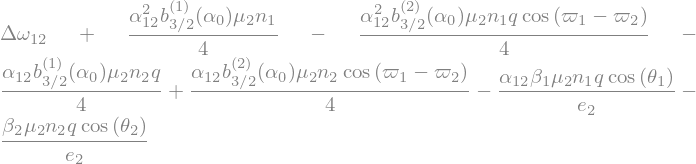

In [155]:
__ = (pom1_dot_res + pom1_dot_sec - pom2_dot_res - pom2_dot_sec).subs(
    {
        #cos(th1): 0, 
        #cos(th2): 0, 
        a1: alpha * a2,
        e1:mu2/mu1*e2,
     }
).subs({
    mu1:mu2*q,
om1: Dom12 + om2
})
__

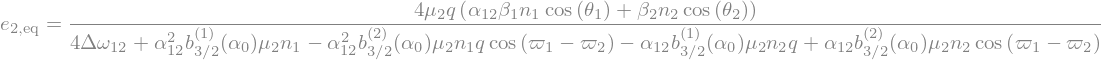

In [156]:
Eq(e2eq,solve(__,e2)[0])

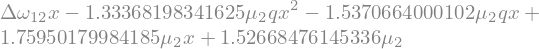

In [ ]:
_poly = (
    (
        __.subs(convs)
        .subs(params)
        .subs({n1: 1, n2: params[j] / (params[j] + 1)})
        .subs(e1, x * e2)
        .subs(pom1 - pom2, pi)
        .subs(om1, Dom12 + om2)
    )
    * x
).expand()
_poly

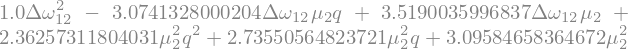

In [ ]:
_disc = ((_poly.coeff(x)) ** 2 - 4 * _poly.subs(x, 0) * _poly.coeff(x**2)).expand()
_disc

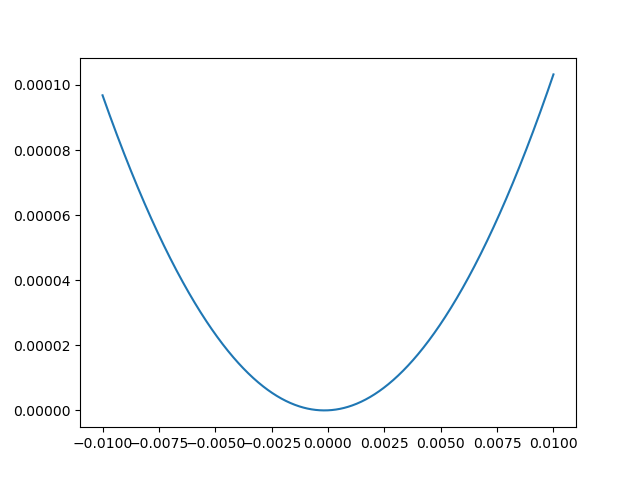

In [ ]:
_Dom12_Dpomeq_func = lambdify([Dom12], _disc.subs({mu2: 1e-4, q: 0.1}))
plt.clf()
_x = npy.linspace(-1e-2, 1e-2, 1000)
plt.plot(_x, _Dom12_Dpomeq_func(_x))
plt.show()

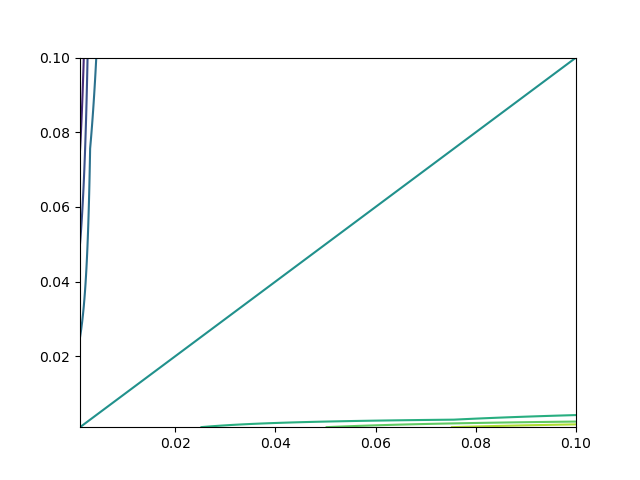

In [ ]:
_x, _y = npy.meshgrid(npy.linspace(0.001, 0.1), npy.linspace(0.001, 0.1))
plt.clf()
plt.contour(_x, _y, (_x / _y - _y / _x))

Assume $\mu_1e_1\ll \mu_2e_2$

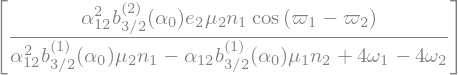

In [ ]:
solve(
    (pom1_dot_res + pom1_dot_sec - pom2_dot_res - pom2_dot_sec).subs(
        {cos(th1): 0, cos(th2): 0, a1: alpha * a2, e1 * mu1: 0}
    ),
    e1,
)

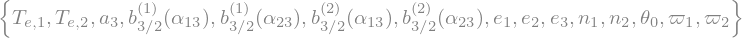

In [ ]:
args = []
for fun in funs:
    args += fun.free_symbols
set(args)

In [231]:
lambdastr(xp, funs, dummify=True).replace("math", "npy")

'lambda _Dummy_99,_Dummy_100,_Dummy_101,_Dummy_102,_Dummy_103,_Dummy_104,_Dummy_105,_Dummy_106,_Dummy_107,_Dummy_108,_Dummy_109,_Dummy_110,_Dummy_111,_Dummy_112,_Dummy_113: ([0.000556392301803571*_Dummy_100**(2/3)*_Dummy_99**(4/3)*_Dummy_101*npy.sin(_Dummy_103 - _Dummy_104) - 0.000682434266857037*_Dummy_100**(2/3)*_Dummy_99**(4/3)*_Dummy_102*npy.sin(_Dummy_103 - _Dummy_105) + 3*_Dummy_101**2*_Dummy_99/_Dummy_112, -0.000417294226352678*_Dummy_100**2*_Dummy_101*npy.sin(_Dummy_103 - _Dummy_104) + 0.000511825700142778*_Dummy_100**2*_Dummy_102*npy.sin(_Dummy_103 - _Dummy_105) + 3*_Dummy_102**2*_Dummy_100/_Dummy_113 + 2.38732414637843e-8*_Dummy_100, -0.000157285601129232*_Dummy_100**(4/3)*_Dummy_102*npy.sin(_Dummy_104 - _Dummy_105)/_Dummy_99**(1/3) + 9.27320503005952e-5*_Dummy_100**(2/3)*_Dummy_101**2*_Dummy_99**(1/3)*npy.sin(_Dummy_103 - _Dummy_104) - 0.000113739044476173*_Dummy_100**(2/3)*_Dummy_99**(1/3)*_Dummy_101*_Dummy_102*npy.sin(_Dummy_103 - _Dummy_105) + 9.27320503005952e-5*_Dummy_1

# Integrations

In [ ]:
def solve_ivp(job):
    ind, GPa3, GPe3, theta0, varpi10, varpi20 = (
        job[0],
        job[1],
        job[2],
        job[3],
        job[4],
        job[5],
    )

    # For now, evaluating at initial conditions...
    # Better check how much it changes runtime or results...
    # Checked -- see notes below
    # VALb1_3_2_13 = LaplaceCoefficients.b(1.5, 1, alpha0val / GPa3)
    # VALb2_3_2_13 = LaplaceCoefficients.b(1.5, 2, alpha0val / GPa3)
    # VALb1_3_2_23 = LaplaceCoefficients.b(1.5, 1, 1 / GPa3)
    # VALb2_3_2_23 = LaplaceCoefficients.b(1.5, 2, 1 / GPa3)

    funcl = lambdify(xp, funs)

    def func(t, x0):
        # x0=[n1, n2, e1, e2, th0, pom1, pom2]

        VALe1 = x0[2]
        VALe2 = x0[3]

        VALte1 = params["Te10"]
        # * (
        #    1 - 0.14 * (VALe1 / params["h"]) ** 2 + 0.06 * (VALe1 / params["h"]) ** 3
        # )
        VALte2 = params["Te20"]
        # * (
        #    1 - 0.14 * (VALe2 / params["h"]) ** 2 + 0.06 * (VALe2 / params["h"]) ** 3
        # )

        VALa1 = x0[0] ** (-2.0 / 3)
        VALa2 = x0[1] ** (-2.0 / 3)

        VALb1_3_2_13 = LaplaceCoefficients.b(1.5, 1, VALa1 / GPa3)
        VALb2_3_2_13 = LaplaceCoefficients.b(1.5, 2, VALa1 / GPa3)
        VALb1_3_2_23 = LaplaceCoefficients.b(1.5, 1, VALa2 / GPa3)
        VALb2_3_2_23 = LaplaceCoefficients.b(1.5, 2, VALa2 / GPa3)

        return funcl(
            *x0,
            GPa3,
            GPe3,
            VALb1_3_2_13,
            VALb2_3_2_13,
            VALb1_3_2_23,
            VALb2_3_2_23,
            VALte1,
            VALte2,
        )

    def event1(t, Y):
        return Y[1] / Y[0] - 0.7

    event1.terminal = True

    teval = npy.linspace(0, 2 * npy.pi * 5e5, 10000)
    sol = sp.integrate.solve_ivp(
        func,
        [teval[0], teval[-1]],
        [1.57, 1, 0.001, 0.001, theta0, varpi10, varpi20],
        t_eval=teval,
        rtol=1e-9,
        atol=1e-9,
        method="DOP853",
        events=[event1],
    )
    if ind % 10 == 0:
        print(f"{ind}...")
    return sol

In [ ]:
# sol = solve_ivp([0, 3, 0.3, 0, -1, -2])
sol = solve_ivp([0, 2, 0.3, 0, 2, -2])
sol

0...


  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  3.142e+02 ...  5.593e+05  5.596e+05]
        y: [[ 1.570e+00  1.570e+00 ...  1.636e+00  1.636e+00]
            [ 1.000e+00  1.000e+00 ...  1.143e+00  1.143e+00]
            ...
            [ 2.000e+00  4.782e+00 ...  3.008e+02  3.008e+02]
            [-2.000e+00 -1.311e+00 ... -4.112e-01 -2.956e-01]]
      sol: None
 t_events: [array([ 5.599e+05])]
 y_events: [array([[ 1.634e+00,  1.144e+00,  1.510e-01,  2.312e-01,
                    1.274e+04,  3.009e+02, -1.781e-01]])]
     nfev: 661691
     njev: 0
      nlu: 0

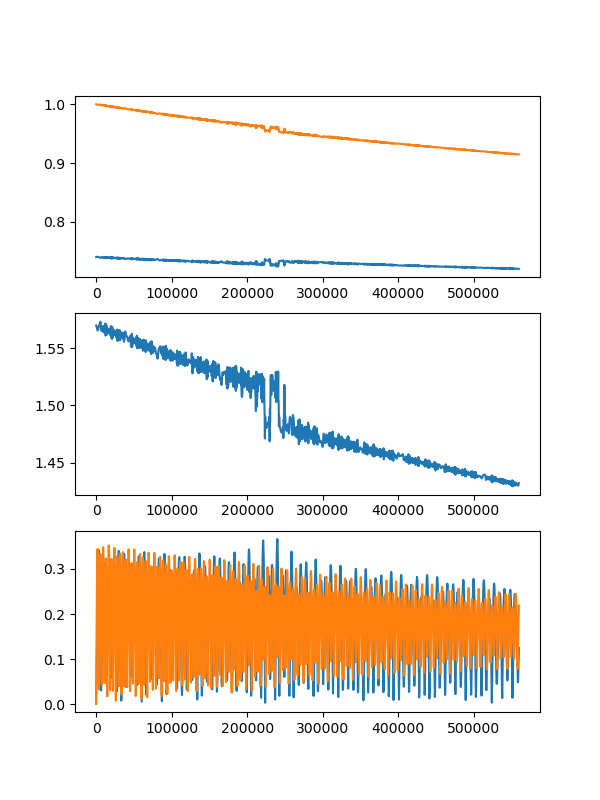

In [ ]:
# sol [n1, n2, e1, e2, th0, pom1, pom2]
plt.clf()
plt.figure(figsize=(6, 8))
plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0, :] ** (-2.0 / 3))
plt.plot(sol.t, sol.y[1, :] ** (-2.0 / 3))
plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[0, :] / sol.y[1, :])
plt.subplot(3, 1, 3)
plt.plot(sol.t, sol.y[2, :])
plt.plot(sol.t, sol.y[3, :])

# Grid

In [ ]:
npy.random.randint(0, 1000, 5)

array([478, 658, 848, 900, 951])

In [16]:
with open("results_1ME_2ME_1MJ_random_grid_constTe_largeh_1000.pkl", "rb") as f:
    README = b""
    while True:
        line = f.readline()
        if line.strip() == b"---":  # Stop at the separator
            break
        README += line
    README = README.decode().strip()
    jobs, results = pickle.load(f)

In [17]:
N_jobs = len(results)
a3s = npy.zeros(N_jobs)
e3s = npy.zeros(N_jobs)
theta0s = npy.zeros(N_jobs)
varpi10s = npy.zeros(N_jobs)
varpi20s = npy.zeros(N_jobs)
outcomes = npy.zeros(N_jobs)

for i in range(N_jobs):
    a3s[i] = jobs[i][1]
    e3s[i] = jobs[i][2]
    theta0s[i] = jobs[i][3]
    varpi10s[i] = jobs[i][4]
    varpi20s[i] = jobs[i][5]
    if len(results[i].t_events[0]) > 0:
        outcomes[i] = 1
print(npy.sum(outcomes))

2.0


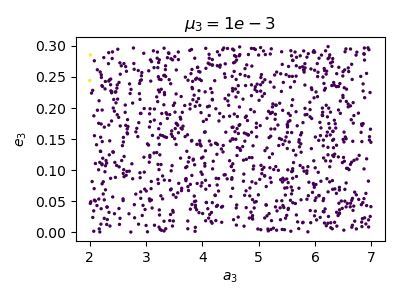

In [ ]:
plt.clf()
plt.figure(figsize=(4, 3))
plt.scatter(a3s, e3s, c=outcomes, s=2)
# for i in range(N_jobs):
#    plt.text(a3s[i], e3s[i], i)
plt.xlabel(r"$a_3$")
plt.ylabel(r"$e_3$")
plt.title(r"$\mu_3=1e-3$")
plt.tight_layout()
# save_to_clipboard()
plt.show()

## Single runs by job index

(157, 2.517174070244473, 0.0008626888514303821, 2.0344320870733674, 1.1603508430330831, 3.4974208765911263)


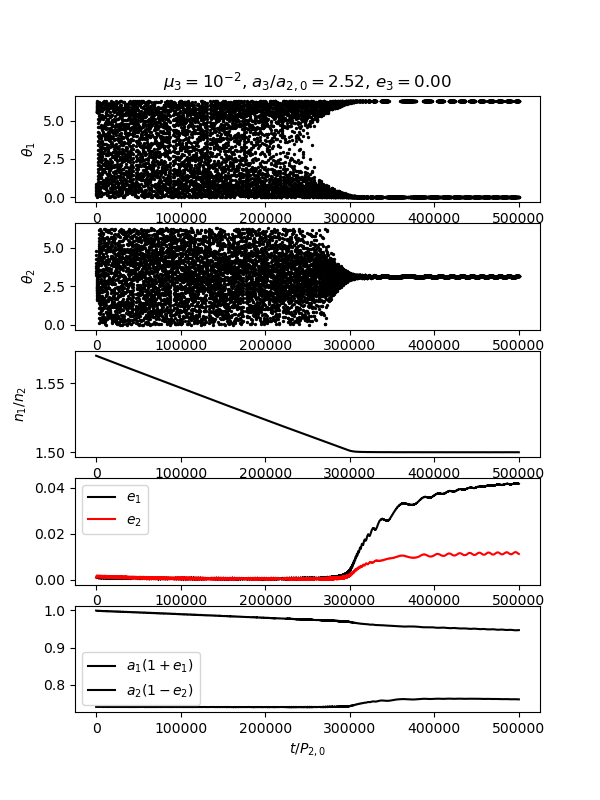

In [ ]:
ind = 157
# Const 1e-2
# ind = 800
# ind = 425
# ind = 855
# ind = 390
# ind = 395
# Realistic 1e-3
# ind = 595
# ind = 327
# ind = 19
# ind = 958
# Const 1e-3
# ind = 555

print(jobs[ind])
# sol [n1, n2, e1, e2, th0, pom1, pom2]
plt.clf()
plt.figure(figsize=(6, 8))
plt.subplot(5, 1, 1)
plt.title(
    r"$\mu_3=10^{-2}$, "
    + f"$a_3/a_{{2,0}}={jobs[ind][1]:0.2f}$, $e_3={jobs[ind][2]:0.2f}$"
)
plt.ylabel(r"$\theta_1$")
plt.scatter(
    results[ind].t / (2 * npy.pi),
    (results[ind].y[4, :] - results[ind].y[5, :]) % (2 * npy.pi),
    s=2,
    c="k",
)
plt.subplot(5, 1, 2)
plt.ylabel(r"$\theta_2$")
plt.scatter(
    results[ind].t / (2 * npy.pi),
    (results[ind].y[4, :] - results[ind].y[6, :]) % (2 * npy.pi),
    s=2,
    c="k",
)
plt.subplot(5, 1, 3)
plt.ylabel(r"$n_1/n_2$")
plt.plot(
    results[ind].t / (2 * npy.pi), results[ind].y[0, :] / results[ind].y[1, :], c="k"
)
plt.subplot(5, 1, 4)
plt.plot(results[ind].t / (2 * npy.pi), results[ind].y[2, :], label=r"$e_1$", c="k")
plt.plot(results[ind].t / (2 * npy.pi), results[ind].y[3, :], label=r"$e_2$", c="r")
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(
    results[ind].t / (2 * npy.pi),
    results[ind].y[0, :] ** (-2.0 / 3) * (1 + results[ind].y[2, :]),
    label=r"$a_1(1+e_1)$",
    c="k",
)
plt.plot(
    results[ind].t / (2 * npy.pi),
    results[ind].y[1, :] ** (-2.0 / 3) * (1 - results[ind].y[3, :]),
    label=r"$a_2(1-e_2)$",
    c="k",
)
plt.legend()

plt.xlabel(r"$t/P_{2,0}$")


save_to_clipboard()

# Run set for comparable mass w/ ad hoc apsidal precession

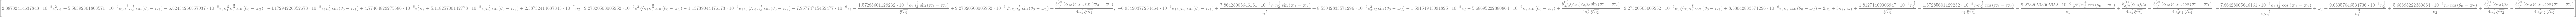

In [ ]:
convs = {
    th1: th0 - pom1,
    th2: th0 - pom2,
    a1: n1 ** -Rational(2, 3),
    a2: n2 ** -Rational(2, 3),
    alpha: a1 / a2,
}
params = {
    j: 2,
    mu1: 3e-6,
    mu2: 6e-6,
    b1: 1.5455341716765871,
    b2: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
    Tm1: np.inf,  # n_{2,0}^{-1}
    Tm2: 1e6 * 2 * np.pi,
}
params[q] = params[mu1] / params[mu2]
params[Te2] = params[Tm2] * 0.01
params[Te1] = params[Te2] / q

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)


_ = [
    n1_dot_res + n1_dot_dis,
    n2_dot_res + n2_dot_dis,
    e1_dot_res + e1_dot_sec + e1_dot_sec13 + e1_dot_dis,
    e2_dot_res + e2_dot_sec + e2_dot_sec23 + e2_dot_dis,
    th0_dot_res,
    pom1_dot_res + pom1_dot_sec + pom1_dot_sec13,
    pom2_dot_res + pom2_dot_sec + pom2_dot_sec23,
]
funs = [iterfun.subs(convs).subs(params).subs(convs) for iterfun in _]

xp = [n1, n2, e1, e2, th0, pom1, pom2, om1, om2]
funs

In [84]:
def solve_ivp(job):
    ind, omega_1, omega_2, theta0, varpi10, varpi20 = (
        job[0],
        job[1],
        job[2],
        job[3],
        job[4],
        job[5],
    )

    funcl = lambdify(xp, funs)

    def func(t, x0):
        return funcl(*x0, omega_1, omega_2)

    def event1(t, Y):
        return Y[1] / Y[0] - 0.7

    event1.terminal = True

    teval = npy.linspace(0, 2 * npy.pi * 0.5e5, 10000)
    sol = sp.integrate.solve_ivp(
        func,
        [teval[0], teval[-1]],
        [1.55, 1, 0.001, 0.001, theta0, varpi10, varpi20],
        t_eval=teval,
        rtol=1e-9,
        atol=1e-9,
        method="DOP853",
        events=[event1],
    )
    if ind % 10 == 0:
        print(f"{ind}...")
    return sol

In [ ]:
# omega0 = 0
# sol1 = solve_ivp([0, omega0 * alpha0val**3.5, omega0, 0, 0.4, 1.35])

In [ ]:
# SEED_1 = 8403
#
# N_jobs = 1000
# rng = np.random.default_rng(SEED_1)
#
# om0vals = rng.choice([-1, 1], size=N_jobs) * npy.power(10, rng.uniform(-6, -3, N_jobs))
# theta0vals = rng.uniform(0, 2 * npy.pi, N_jobs)
# pom10vals = rng.uniform(0, 2 * npy.pi, N_jobs)
# pom20vals = rng.uniform(0, 2 * npy.pi, N_jobs)
#
# jobs = []
## ind, omega_1, omega_2, theta0, varpi10, varpi20
# for i in range(N_jobs):
#    jobs += [
#        (
#            i,
#            om0vals[i] * alpha0val**3.5,
#            om0vals[i],
#            theta0vals[i],
#            pom10vals[i],
#            pom20vals[i],
#        )
#    ]
# jobs

In [ ]:
# executors_solve_ivp = get_reusable_executor(max_workers=16)
# results = list(executors_solve_ivp.map(solve_ivp, jobs))
# with open(
#    f"cm_m1_3e-6_q0.5_tm2pi1e6_n10_1.55_omalpha0val3.5_random{N_jobs}.pkl", "wb"
# ) as f:
#    pickle.dump([jobs, results], f)

0...
100...
200...
300...
400...
500...
600...
700...
800...
900...


In [209]:
outcomes = [0 for _ in range(len(results))]
for i in range(len(results)):
    if len(results[i].t_events[0]) > 0:
        outcomes[i] = 1

In [211]:
sum(outcomes)

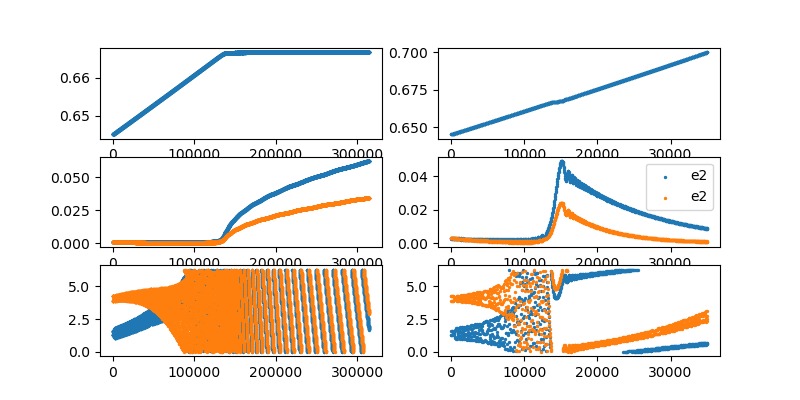

In [183]:
# sol [n1, n2, e1, e2, th0, pom1, pom2]
plt.clf()
plt.figure(figsize=(8, 4))

################################################
plt.subplot(3, 2, 1)
plt.scatter(sol0.t, sol0.y[1] / sol0.y[0], s=2)
plt.subplot(3, 2, 2)
plt.scatter(sol1.t, sol1.y[1] / sol1.y[0], s=2)

################################################
plt.subplot(3, 2, 3)
plt.scatter(sol0.t, sol0.y[2], s=2)
plt.scatter(sol0.t, sol0.y[3], s=2)
plt.subplot(3, 2, 4)
plt.scatter(sol1.t, sol1.y[2] % 2 * np.pi, s=2, label="e2")
plt.scatter(sol1.t, sol1.y[3] % 2 * np.pi, s=2, label="e2")
plt.legend()

################################################
plt.subplot(3, 2, 5)
plt.scatter(sol0.t, sol0.y[5] % 2 * np.pi, s=2)
plt.scatter(sol0.t, sol0.y[6] % 2 * np.pi, s=2)
plt.subplot(3, 2, 6)
plt.scatter(sol1.t, sol1.y[5] % 2 * np.pi, s=2)
plt.scatter(sol1.t, sol1.y[6] % 2 * np.pi, s=2)

plt.show()

# Frequency plots